## fraud detection

In [95]:
import pandas as pd
import numpy as np
import random
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

### load dataset

In [36]:
df = pd.read_csv("synthetic_expenses.csv")

### enhance dataset for testing

In [37]:
df = pd.concat([df, df.head(3)], ignore_index=True)
df.loc[len(df)] = df.loc[0].copy()
df.loc[len(df)-1, 'Description'] = df.loc[len(df)-1, 'Description'] + " slight change"

df.loc[len(df)] = {
    "Employee_ID": 1,
    "Expense_Amount": df['Expense_Amount'].max()*5,
    "Currency": "USD",
    "Category": "Travel",
    "Description": "Luxury flight for testing",
    "Date": "2025-10-01",
    "Approved/Rejected": "Approved"
}

df['Vendor'] = [f"Vendor_{random.randint(1,10)}" for _ in range(len(df))]
df['Department'] = [random.choice(['HR', 'Finance', 'IT', 'Sales']) for _ in range(len(df))]
df['Location'] = [random.choice(['USA', 'UK', 'IN', 'AU', 'EU']) for _ in range(len(df))]

### Exact duplication detection

In [38]:
df['Exact_Duplicate'] = df.duplicated(subset=['Employee_ID', 'Expense_Amount', 'Category', 'Date'], keep=False)

print("Exact duplicates found:")
print(df[df['Exact_Duplicate'] == True])

Exact duplicates found:
      Employee_ID  Expense_Amount Currency       Category  \
0              33          596.13      INR         Travel   
1              35          957.62      INR  Accommodation   
2              46          615.08      INR  Accommodation   
1000           33          596.13      INR         Travel   
1001           35          957.62      INR  Accommodation   
1002           46          615.08      INR  Accommodation   
1003           33          596.13      INR         Travel   

                                            Description        Date  \
0              Player development local structure whom.  2025-09-23   
1                           She discover natural right.  2025-03-17   
2                              Clearly young walk road.  2025-08-01   
1000           Player development local structure whom.  2025-09-23   
1001                        She discover natural right.  2025-03-17   
1002                           Clearly young walk road.  2025

### Near duplicate detection

In [39]:
def find_near_duplicates(df, threshold=90):
    near_duplicates = []
    for i in range(len(df)):
        for j in range(i+1, len(df)):
            if (df.loc[i, 'Employee_ID'] == df.loc[j, 'Employee_ID'] and
                df.loc[i, 'Expense_Amount'] == df.loc[j, 'Expense_Amount'] and
                df.loc[i, 'Date'] == df.loc[j, 'Date'] and
                df.loc[i, 'Category'] == df.loc[j, 'Category']):
                
                score = fuzz.ratio(str(df.loc[i, 'Description']), str(df.loc[j, 'Description']))
                if score >= threshold:
                    near_duplicates.append((i, j, score))
    return near_duplicates

In [40]:
near_dupes = find_near_duplicates(df)
df['Near_Duplicate'] = False
for i, j, score in near_dupes:
    df.at[i, 'Near_Duplicate'] = True
    df.at[j, 'Near_Duplicate'] = True

print(f"\nNear-duplicates found: {len(near_dupes)}")
for nd in near_dupes[:10]:
    print(nd)


Near-duplicates found: 3
(0, 1000, 100)
(1, 1001, 100)
(2, 1002, 100)


### Unusual spending pattern

In [41]:
X = df[['Employee_ID', 'Expense_Amount']]
iso = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly'] = iso.fit_predict(X) 
df['Anomaly'] = df['Anomaly'].map({1: False, -1: True})

print("\nAnomalous expenses detected:")
print(df[df['Anomaly'] == True])



Anomalous expenses detected:
      Employee_ID  Expense_Amount Currency       Category  \
3              48           37.15      GBP  Accommodation   
15              1          913.46      INR       Supplies   
43              2           57.10      AUD  Accommodation   
68              1          788.92      EUR       Supplies   
73             47           78.42      EUR       Supplies   
83             50          896.42      AUD         Travel   
133            44           11.98      EUR         Travel   
150             5          999.61      EUR  Entertainment   
153            50          419.40      USD          Meals   
160             5           19.12      INR          Meals   
186            47           12.48      USD         Travel   
208            49           95.06      EUR  Accommodation   
213            50          705.87      EUR         Travel   
288            50          830.02      EUR          Meals   
300             4           18.07      INR  Entertainme

### Suspecious claims

In [42]:
category_mean = df.groupby('Category')['Expense_Amount'].transform('mean')
df['Suspicious'] = df['Expense_Amount'] > 3 * category_mean

print("\nSuspicious claims based on 3x category mean:")
print(df[df['Suspicious'] == True])


Suspicious claims based on 3x category mean:
      Employee_ID  Expense_Amount Currency Category  \
1004            1          4998.1      USD   Travel   

                    Description        Date Approved/Rejected    Vendor  \
1004  Luxury flight for testing  2025-10-01          Approved  Vendor_6   

     Department Location  Exact_Duplicate  Near_Duplicate  Anomaly  Suspicious  
1004    Finance       EU            False           False     True        True  


### Fraud score

In [44]:
df['Fraud_Score'] = df[['Exact_Duplicate', 'Near_Duplicate', 'Anomaly', 'Suspicious']].sum(axis=1)

print("\nTop potential frauds (by score):")
print(df.sort_values('Fraud_Score', ascending=False).head(10))
df.to_csv("enhanced_synthetic_expenses.csv", index=False)



Top potential frauds (by score):
      Employee_ID  Expense_Amount Currency       Category  \
1004            1         4998.10      USD         Travel   
0              33          596.13      INR         Travel   
1              35          957.62      INR  Accommodation   
2              46          615.08      INR  Accommodation   
1001           35          957.62      INR  Accommodation   
1002           46          615.08      INR  Accommodation   
1000           33          596.13      INR         Travel   
3              48           37.15      GBP  Accommodation   
1003           33          596.13      INR         Travel   
983            50          555.18      USD       Supplies   

                                            Description        Date  \
1004                          Luxury flight for testing  2025-10-01   
0              Player development local structure whom.  2025-09-23   
1                           She discover natural right.  2025-03-17   
2         

## Predictive analysis

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

In [45]:
df['Date'] = pd.to_datetime(df['Date'])

### Aggregate data

In [46]:
employee_id = 1
employee_df = df[df['Employee_ID'] == employee_id]

monthly_expense = employee_df.groupby(pd.Grouper(key='Date', freq='M'))['Expense_Amount'].sum().reset_index()
monthly_expense.rename(columns={'Date': 'ds', 'Expense_Amount': 'y'}, inplace=True)

print("\nMonthly aggregated expenses for Employee_ID =", employee_id)
print(monthly_expense)


Monthly aggregated expenses for Employee_ID = 1
          ds        y
0 2025-01-31  1104.30
1 2025-02-28   820.35
2 2025-03-31   705.53
3 2025-04-30   709.55
4 2025-05-31  1501.83
5 2025-06-30   798.11
6 2025-07-31   933.68
7 2025-08-31   831.89
8 2025-09-30   473.74
9 2025-10-31  4998.10


C:\Users\Avani N. Goswami\AppData\Local\Temp\ipykernel_692\862888164.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_expense = employee_df.groupby(pd.Grouper(key='Date', freq='M'))['Expense_Amount'].sum().reset_index()


### Prophet model for forcasting

In [51]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(monthly_expense)
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

14:56:00 - cmdstanpy - INFO - Chain [1] start processing
14:56:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Avani N. Goswami\AppData\Roaming\Python\Python313\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


### Plot forecaste

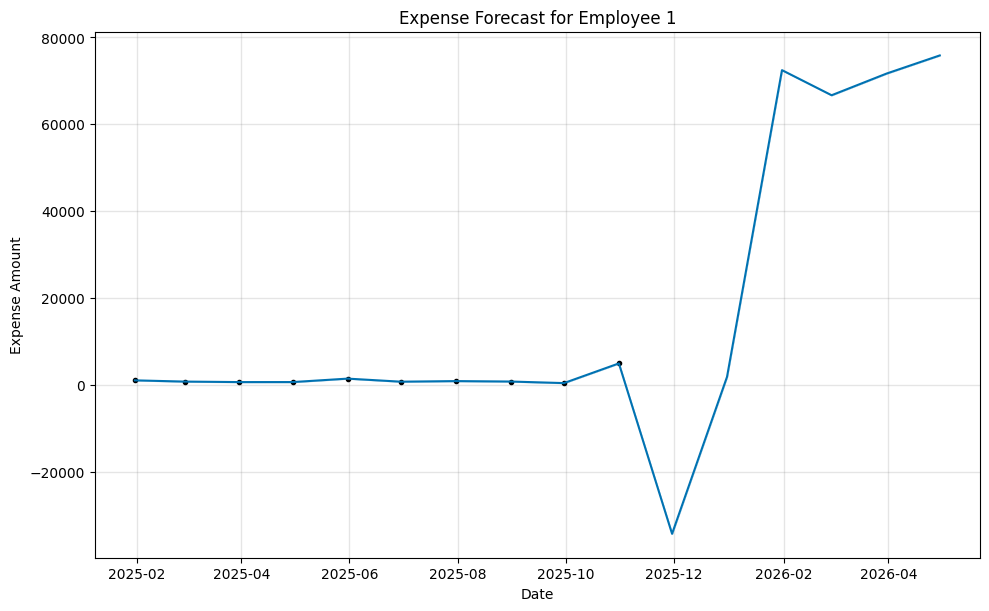

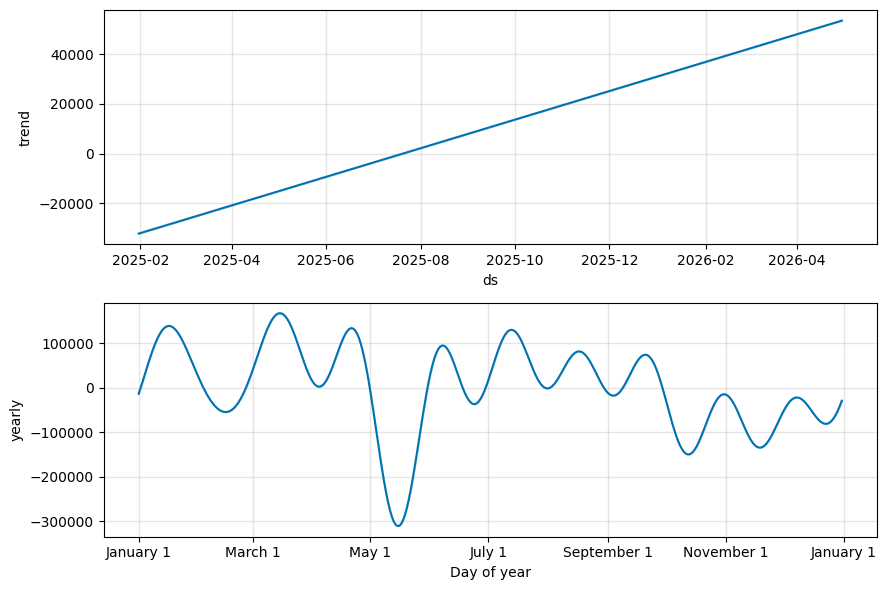

In [50]:
fig1 = model.plot(forecast)
plt.title(f"Expense Forecast for Employee {employee_id}")
plt.xlabel("Date")
plt.ylabel("Expense Amount")
plt.show()
fig2 = model.plot_components(forecast)
plt.show()

### forecaste by category

C:\Users\Avani N. Goswami\AppData\Local\Temp\ipykernel_692\2017826599.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_cat_expense = cat_df.groupby(pd.Grouper(key='Date', freq='M'))['Expense_Amount'].sum().reset_index()
14:55:41 - cmdstanpy - INFO - Chain [1] start processing
14:55:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Avani N. Goswami\AppData\Roaming\Python\Python313\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


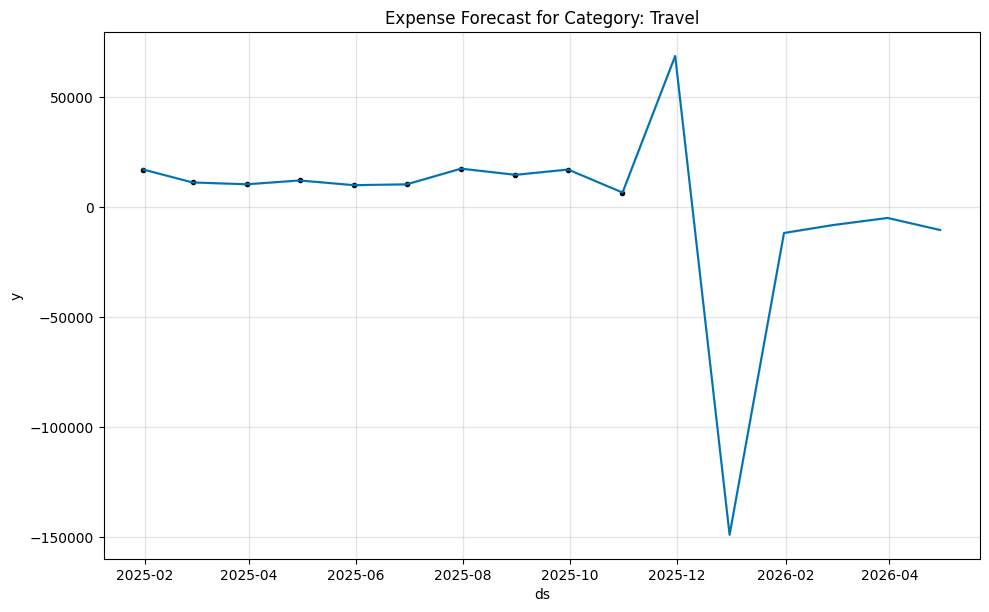

In [49]:
category = 'Travel'
cat_df = df[df['Category'] == category]

monthly_cat_expense = cat_df.groupby(pd.Grouper(key='Date', freq='M'))['Expense_Amount'].sum().reset_index()
monthly_cat_expense.rename(columns={'Date': 'ds', 'Expense_Amount': 'y'}, inplace=True)

cat_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
cat_model.fit(monthly_cat_expense)

future_cat = cat_model.make_future_dataframe(periods=6, freq='M')
forecast_cat = cat_model.predict(future_cat)

cat_model.plot(forecast_cat)
plt.title(f"Expense Forecast for Category: {category}")
plt.show()

## Anomaly detection

### Inject some anamolies

In [54]:
for i in np.random.choice(df.index, 10, replace=False):
    df.loc[i, 'Expense_Amount'] = np.random.randint(10000, 30000) 

print("Data Loaded. Sample:")
print(df.head(), "\n")

Data Loaded. Sample:
   Employee_ID  Expense_Amount Currency       Category  \
0           33          596.13      INR         Travel   
1           35          957.62      INR  Accommodation   
2           46          615.08      INR  Accommodation   
3           48           37.15      GBP  Accommodation   
4           48          622.20      USD          Meals   

                                Description       Date Approved/Rejected  \
0  Player development local structure whom. 2025-09-23          Approved   
1               She discover natural right. 2025-03-17          Approved   
2                  Clearly young walk road. 2025-08-01          Approved   
3              Available between ahead kid. 2025-07-01          Rejected   
4              Talk chair late name he cup. 2025-04-20          Approved   

     Vendor Department Location  Exact_Duplicate  Near_Duplicate  Anomaly  \
0  Vendor_1         IT       AU             True            True    False   
1  Vendor_2        

### Feature engineering

In [55]:
df['Month'] = df['Date'].dt.to_period('M')
monthly_expense = df.groupby(['Employee_ID', 'Month'])['Expense_Amount'].sum().reset_index()
monthly_expense['Month'] = monthly_expense['Month'].astype(str)

### Isolation Forest model

In [63]:
iso_forest = IsolationForest(contamination=0.03, random_state=42)
monthly_expense['anomaly_score_iso'] = iso_forest.fit_predict(monthly_expense[['Expense_Amount']])
monthly_expense['Anomaly_IF'] = monthly_expense['anomaly_score_iso'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

### Local factor outlier model

In [57]:
lof = LocalOutlierFactor(contamination=0.03)
monthly_expense['anomaly_score_lof'] = lof.fit_predict(monthly_expense[['Expense_Amount']])
monthly_expense['Anomaly_LOF'] = monthly_expense['anomaly_score_lof'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

### Visualize detected anamoly

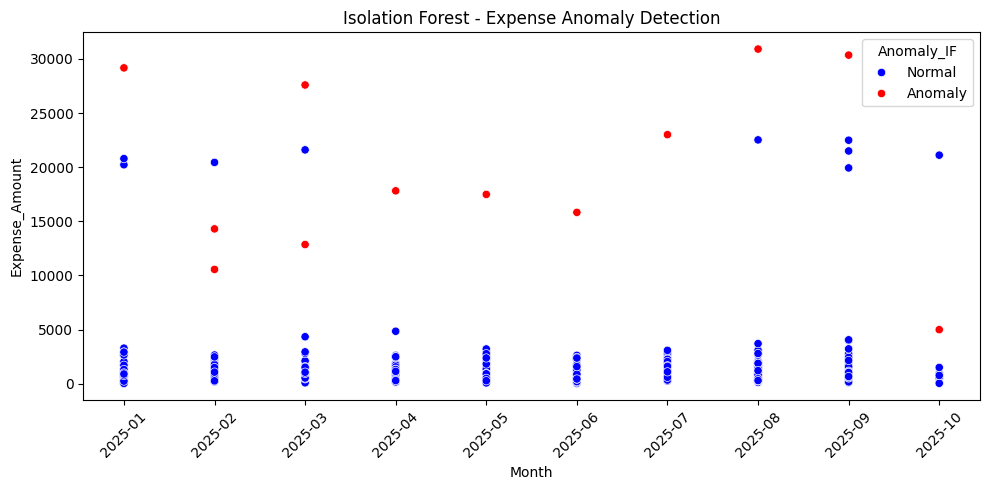

In [59]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=monthly_expense, x='Month', y='Expense_Amount', hue='Anomaly_IF', palette={'Normal':'blue','Anomaly':'red'})
plt.title("Isolation Forest - Expense Anomaly Detection")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Merge anamoly flag with original data

In [60]:
df['Month'] = df['Date'].dt.to_period('M').astype(str)
df = df.merge(monthly_expense[['Employee_ID','Month','Anomaly_IF','Anomaly_LOF']], on=['Employee_ID','Month'], how='left')

print("Sample of Final Data with Anomaly Labels:")
print(df.head(10))

Sample of Final Data with Anomaly Labels:
   Employee_ID  Expense_Amount Currency       Category  \
0           33          596.13      INR         Travel   
1           35          957.62      INR  Accommodation   
2           46          615.08      INR  Accommodation   
3           48           37.15      GBP  Accommodation   
4           48          622.20      USD          Meals   
5           18          588.48      GBP          Meals   
6           22          483.90      AUD       Supplies   
7            2          665.00      GBP         Travel   
8           47          493.55      EUR  Entertainment   
9           16          557.62      EUR  Accommodation   

                                         Description       Date  \
0           Player development local structure whom. 2025-09-23   
1                        She discover natural right. 2025-03-17   
2                           Clearly young walk road. 2025-08-01   
3                       Available between ahead kid

### Summary

In [64]:
print("\n Anomaly Summary (Isolation Forest):")
print(monthly_expense['Anomaly_IF'].value_counts())



 Anomaly Summary (Isolation Forest):
Anomaly_IF
Normal     389
Anomaly     12
Name: count, dtype: int64


## Smart Approval Suggestions

In [96]:
df = pd.read_csv("synthetic_expenses.csv")

### Data preprocessing

#### dropping missing values

In [66]:
df = df.dropna()

#### encode categorical variable

In [67]:
label_encoders = {}
for col in ['Employee_ID', 'Currency', 'Category', 'Description', 'Approved/Rejected']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

### feature and target selection

In [68]:
X = df[['Employee_ID', 'Expense_Amount', 'Currency', 'Category', 'Description']]
y = df['Approved/Rejected']

### splitting dataset

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scale numeric value

In [70]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### train model

In [71]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

### evaluate model


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       170
           1       0.00      0.00      0.00        31

    accuracy                           0.83       201
   macro avg       0.42      0.49      0.45       201
weighted avg       0.71      0.83      0.77       201



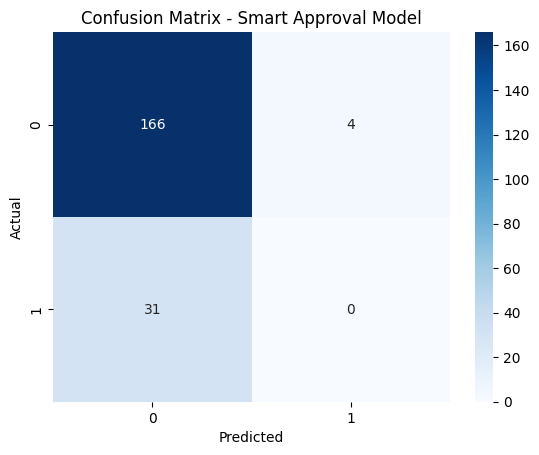

In [73]:
y_pred = model.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Smart Approval Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### feature importance

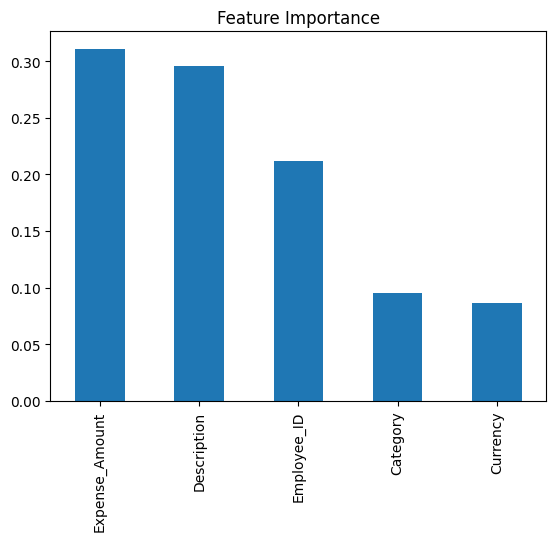


Feature Importances:
Expense_Amount    0.310706
Description       0.295824
Employee_ID       0.211502
Category          0.095056
Currency          0.086911
dtype: float64


In [74]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', title="Feature Importance")
plt.show()

print("\nFeature Importances:")
print(importances.sort_values(ascending=False))

### handle unseen labels gracefully

In [75]:
def safe_transform(le, values):
    """Transform new categorical values safely (replace unseen with 0)."""
    known_classes = set(le.classes_)
    result = []
    for v in values:
        if v in known_classes:
            result.append(le.transform([v])[0])
        else:
            print(f"⚠️ Warning: unseen label '{v}' replaced with default class '{le.classes_[0]}'")
            result.append(le.transform([le.classes_[0]])[0])
    return result

### smart approval suggestion

In [76]:
new_expense_raw = {
    'Employee_ID': ['E12'],          # unseen employee (will be handled)
    'Expense_Amount': [1800],
    'Currency': ['USD'],
    'Category': ['Meals'],
    'Description': ['Team lunch']
}

#### convert encoded form

In [77]:
new_expense = pd.DataFrame({
    'Employee_ID': safe_transform(label_encoders['Employee_ID'], new_expense_raw['Employee_ID']),
    'Expense_Amount': new_expense_raw['Expense_Amount'],
    'Currency': safe_transform(label_encoders['Currency'], new_expense_raw['Currency']),
    'Category': safe_transform(label_encoders['Category'], new_expense_raw['Category']),
    'Description': safe_transform(label_encoders['Description'], new_expense_raw['Description']),
})

⚠️ Warning: unseen label 'E12' replaced with default class '1'
⚠️ Warning: unseen label 'Team lunch' replaced with default class 'Ability he age ahead spring.'


#### scale the data

In [78]:
new_expense_scaled = scaler.transform(new_expense)

#### predict approval likelihood

In [80]:
pred = model.predict(new_expense_scaled)[0]
suggestion = "Likely to be Approved" if pred == 1 else "Likely to be Rejected"

print("\nSmart Suggestion for the New Expense:")
print(f"Expense Details: {new_expense_raw}")
print(f"AI Suggestion: {suggestion}")


Smart Suggestion for the New Expense:
Expense Details: {'Employee_ID': ['E12'], 'Expense_Amount': [1800], 'Currency': ['USD'], 'Category': ['Meals'], 'Description': ['Team lunch']}
AI Suggestion: Likely to be Rejected


## NLP based insights

In [84]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Avani N.
[nltk_data]     Goswami\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [85]:
df = pd.read_csv("synthetic_expenses.csv")  # same file you used earlier
print("Dataset loaded. Shape:", df.shape)
print(df.head())

Dataset loaded. Shape: (1000, 7)
   Employee_ID  Expense_Amount Currency       Category  \
0           33          596.13      INR         Travel   
1           35          957.62      INR  Accommodation   
2           46          615.08      INR  Accommodation   
3           48           37.15      GBP  Accommodation   
4           48          622.20      USD          Meals   

                                Description        Date Approved/Rejected  
0  Player development local structure whom.  2025-09-23          Approved  
1               She discover natural right.  2025-03-17          Approved  
2                  Clearly young walk road.  2025-08-01          Approved  
3              Available between ahead kid.  2025-07-01          Rejected  
4              Talk chair late name he cup.  2025-04-20          Approved  


### clean description test

In [86]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)  # remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

In [87]:
df['Cleaned_Description'] = df['Description'].apply(clean_text)

### remove stopwords

In [88]:
stop_words = set(stopwords.words('english'))
df['Cleaned_Description'] = df['Cleaned_Description'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

### TF-IDF Vcetorization

In [89]:
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Cleaned_Description'])
tfidf_feature_names = tfidf.get_feature_names_out()

### topic modeling

In [90]:
num_topics = 4
nmf = NMF(n_components=num_topics, random_state=42)
nmf_topics = nmf.fit_transform(tfidf_matrix)

def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        print(f"Topic {topic_idx+1}: {' | '.join(top_words)}")

print("\n Discovered Topics:")
display_topics(nmf, tfidf_feature_names, 8)


 Discovered Topics:
Topic 1: image | data | game | kid | international | management | design | improve
Topic 2: democratic | new | view | stuff | school | race | scene | wonder
Topic 3: late | natural | similar | cost | spring | student | require | control
Topic 4: structure | imagine | gas | accept | player | produce | trial | cultural


### K means clustering

In [91]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(tfidf_matrix)

print("\nSample Cluster Assignments:")
print(df[['Description', 'Cluster']].head(10))


Sample Cluster Assignments:
                                         Description  Cluster
0           Player development local structure whom.        2
1                        She discover natural right.        2
2                           Clearly young walk road.        2
3                       Available between ahead kid.        2
4                       Talk chair late name he cup.        2
5       Always offer history ground they simply act.        1
6                                   Huge show along.        2
7  Morning employee economy today hospital wall p...        2
8  Team success during five drop property nearly ...        2
9    Conference this those today morning two recent.        2


### wordcloud visualization

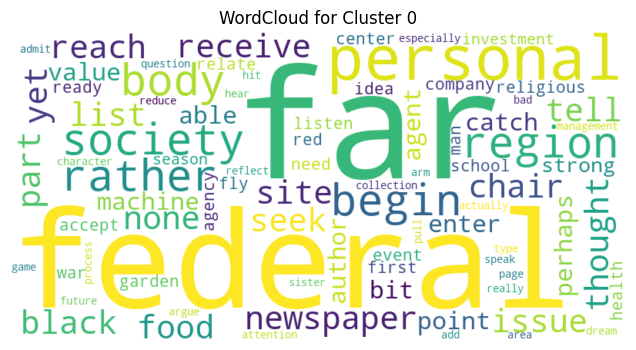

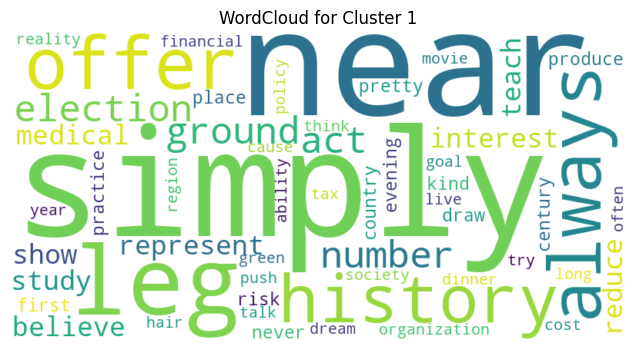

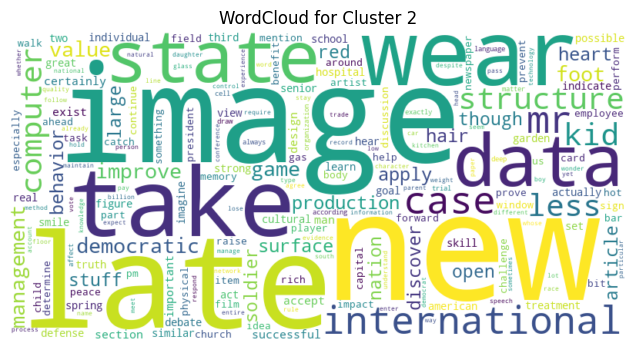

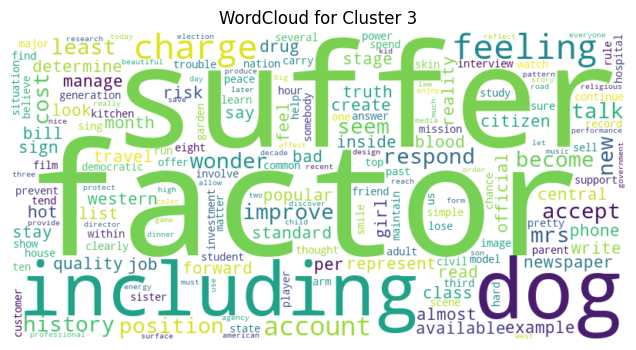

In [92]:
for i in range(4):
    cluster_text = ' '.join(df[df['Cluster'] == i]['Cleaned_Description'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for Cluster {i}')
    plt.show()


### insight extraction

In [93]:
for i in range(num_topics):
    top_words = [tfidf_feature_names[idx] for idx in nmf.components_[i].argsort()[-5:]]
    print(f"Topic {i+1}: Common expense terms — {', '.join(top_words)}")

# Example Analysis
most_common_clusters = df['Cluster'].value_counts().idxmax()
print(f"\nMost common expense cluster: Cluster {most_common_clusters}")
print(f"Example Descriptions:\n{df[df['Cluster']==most_common_clusters]['Description'].head(5).to_list()}")


Topic 1: Common expense terms — international, kid, game, data, image
Topic 2: Common expense terms — school, stuff, view, new, democratic
Topic 3: Common expense terms — spring, cost, similar, natural, late
Topic 4: Common expense terms — player, accept, gas, imagine, structure

Most common expense cluster: Cluster 2
Example Descriptions:
['Player development local structure whom.', 'She discover natural right.', 'Clearly young walk road.', 'Available between ahead kid.', 'Talk chair late name he cup.']
